# II- ML Technics to predict the Probability to receive a Mobile payement

In the context of mobile money wages payment, prior studies have primarily used discrete choice models or structural equations to investigate the factors driving mobile money payment adoption. However, as digitalization is a complex process that requires a multidisciplinary approach, machine learning techniques can be employed to supplement traditional research methods by uncovering complex and non-obvious patterns hidden in large datasets. Over the years, machine learning algorithms have gained increasing popularity for predicting various phenomena in economics, including the adoption of digital payments. Rather than pre-selecting a default machine learning technique, several methods are considered to choose the one with the best performance in terms of accuracy for predicting the likelihood of an employee receiving a mobile money payment. Therefore, the present study delves into an exploration of various machine learning techniques, namely Logistic Regression (LR), Random Forest (RF), Gradient Boosting  (GB), and Feedforward Neural Network (FNN). 

## Neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform as uniform
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
plt.style.use('fivethirtyeight')
#sns.set_palette("colorblind")
#sns.set_style('whitegrid')
import random
np.random.seed(123)  

/home/dhorasso/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


 Read the data

In [2]:
data = pd.read_csv('Data_clean.csv')
data

,a6b,b7,b7a,DL,d1a1a,d2,MMs3,MMs5,MMs7,MMs9,MMs12,e1,k6
0,Small,20 - 40,No,Medium,Retail trade of,500 000 - 50 million,No,No,No,No,No,Local,No
1,Small,20 <,No,Low,Manufacturing of,500 000 - 50 million,No,No,No,No,No,International,Yes
2,Small,20 <,No,Medium,Retail trade of,500 000 - 50 million,No,No,No,No,No,International,Yes
3,Small,20 <,No,Medium,Manufacturing of,500 000 - 50 million,No,No,No,No,No,Local,No
4,Medium,20 <,No,Low,Manufacturing of,50 millions - 1 bilion,No,No,No,No,No,National,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Medium,20 <,No,High,Manufacturing of,50 millions - 1 bilion,No,No,Yes,Yes,No,National,Yes
997,Large,20 <,No,High,Manufacturing of,NaN,No,No,No,No,No,National,Yes
998,Medium,20 - 40,No,Medium,Wholesale trade of,50 millions - 1 bilion,No,No,No,Yes,No,International,Yes
999,Medium,20 - 40,No,High,Manufacturing of,50 millions - 1 bilion,No,No,No,No,No,National,Yes


### Note !!!: THE TARGET VARIABLE IS MMs3

## II.1- Data encoding

Methode1: Label encoder

In [3]:
df=data.copy()
le = LabelEncoder()
df = df.apply(le.fit_transform)
X = df.drop("MMs3", axis=1)
y = df["MMs3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

Method 2: ged_demies

In [4]:
# df["MMs3"] = df["MMs3"].replace({'Yes': 1, 'No': 0})
# X = df.drop("MMs3", axis=1)
# y = df["MMs3"]
# X=pd.get_dummies(X).astype(int)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# oversampler = RandomOverSampler(random_state=42)
# X_train, y_train = oversampler.fit_resample(X_train, y_train)



To evaluate the performance of our machine learning models, we employed various techniques and metrics. Firstly, we split our dataset into a training set (80\%) and a test set (20\%) to assess model performance on unseen data. To address the inherent imbalance in the data, with fewer positive cases representing enterprises that paid their employees through mobile money, we used oversampling techniques to balance the training set \citep{luengo2011addressing}. Additionally, we conducted 5-fold cross-validation to ensure model stability and mitigate the risk of overfitting. To assess the performance of the four machine learning algorithms, a Cross-Validation approach was employed. The training set was divided into five subsets, where four subsets were used for training the models and the remaining subset was utilized for validation. This process was repeated five times, each time with a different subset assigned for validation.

## ||.2 Random Forest

In [5]:
param_dist = {
    'n_estimators': randint(200, 1000),
    'max_depth': randint(5, 10)}

# Create a RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Create a RandomizedSearchCV object with 5-fold cross-validation
random_search = RandomizedSearchCV(model_rf,
                                   param_distributions=param_dist, 
                                   n_iter=10,
                                   cv=cv,
                                   scoring='accuracy',
                                   n_jobs=-1, 
                                   random_state=42)

# Fit the RandomizedSearchCV object to the oversampled training data
random_search.fit(X_train, y_train)

# Retrieve the best estimator and best hyperparameters from the RandomizedSearchCV object
model_rf = random_search.best_estimator_
print("Best hyperparameters: ", random_search.best_params_)

# Predict on the test set and model performance
y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print("Accuracy:", accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)

# Compute AUC
y_scores = model_rf.predict_proba(X_test)[:, 1]
fpr_1, tpr_1, thresholds = roc_curve(y_test, y_scores)
roc_auc_1 = auc(fpr_1, tpr_1)
print("AUC:", roc_auc_1)

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nes

Best hyperparameters:  {'max_depth': 9, 'n_estimators': 299}
Accuracy: 0.8258706467661692
Precision: 0.6333017077798861
Recall: 0.6543956043956044
F1-score: 0.6422578184591915
AUC: 0.7996703296703297


### ROC curve

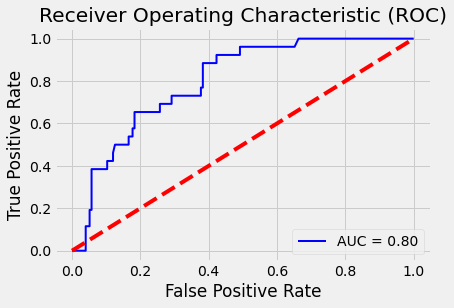

In [6]:

plt.plot(fpr_1, tpr_1, 'b',lw=2, label='AUC = %0.2f' % roc_auc_1)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Receiver Operating Characteristic (ROC)")
plt.show()



### Feature analysis with SHAP method

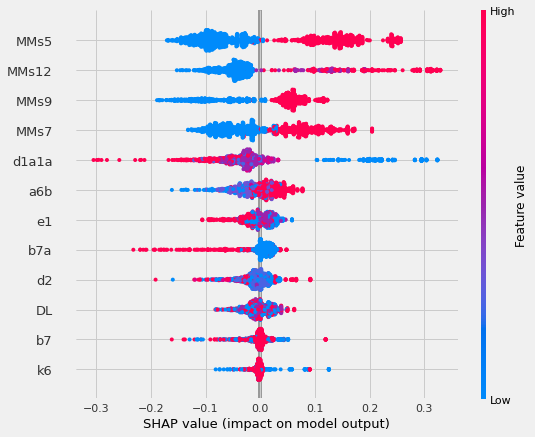

In [7]:

# Create a SHAP explainer object for the fitted RandomForestClassifier model
explainer = shap.Explainer(model_rf)

# Calculate SHAP values for all test set features
shap_values = explainer(X_train)

shap.summary_plot(shap_values[:, :, 1],X_train, show=False)

plt.show()


## Future importances

Permutation explainer: 1379it [15:00,  1.52it/s]                          


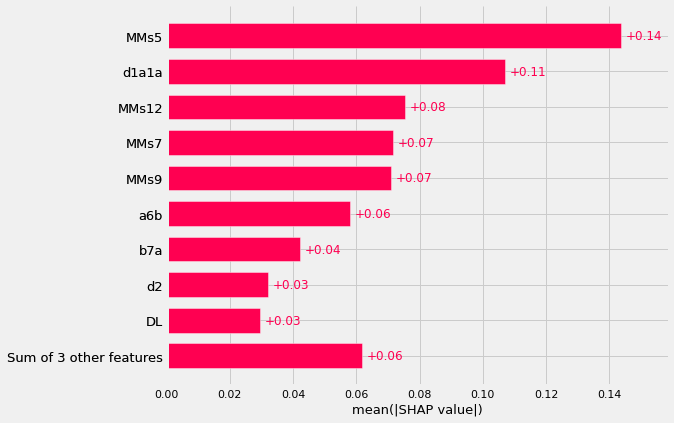

In [8]:
explainer = shap.Explainer(model_rf.predict,X_train)
shap_values = explainer(X_train)

shap.plots.bar(shap_values)

### Local explanation

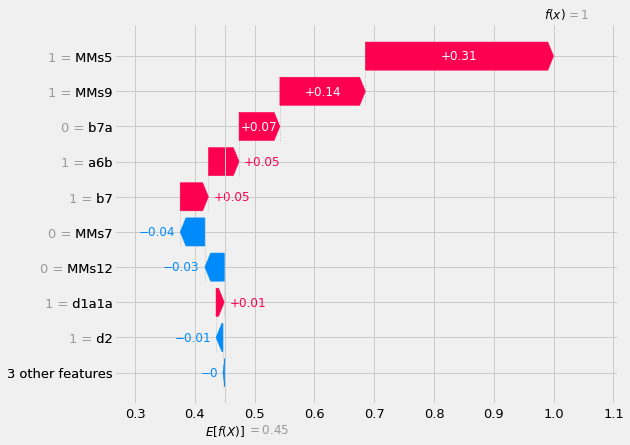

In [9]:

shap.plots.waterfall(shap_values[0])


### Confusion matrix

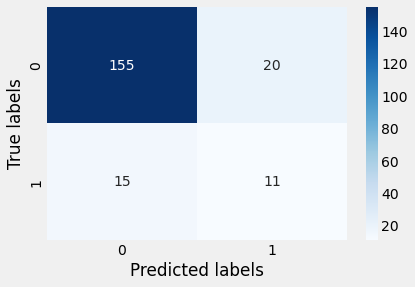

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       175
           1       0.35      0.42      0.39        26

    accuracy                           0.83       201
   macro avg       0.63      0.65      0.64       201
weighted avg       0.84      0.83      0.83       201



In [10]:

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print(classification_report(y_test, y_pred))

## II.3-  Gradient Boosting

In [11]:

model_gb = GradientBoostingClassifier()

# Define a cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter distribution to sample from
param_dist = {
    'n_estimators': randint(200, 1100),
    'max_depth': randint(5, 10),
    'learning_rate': uniform(0.01, 0.5)
}

# Initialize the RandomizedSearchCV object
grid_search = RandomizedSearchCV(
    estimator=model_gb, 
    param_distributions=param_dist,
    cv=cv, 
    n_jobs=-1, 
    verbose=0,
    random_state=42,
    n_iter=20,  # number of parameter combinations to try
     scoring='accuracy' # you can also use other metrics like roc_auc, f1_macro, etc.
)

# Fit the RandomizedSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator from the search
model_gb= grid_search.best_estimator_

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

# Predict on the test set using the best estimator
y_pred = model_gb.predict(X_test)

# Evaluate the performance of the best estimator on the test set
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)

# Compute the AUC-ROC score on the test set
y_scores = model_gb.predict_proba(X_test)[:, 1]
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_scores)
roc_auc_2 = auc(fpr_2, tpr_2)
print("AUC:", roc_auc_2)

Best hyperparameters:  {'learning_rate': 0.4399702033681603, 'max_depth': 9, 'n_estimators': 1040}
Accuracy: 0.8606965174129353
Precision: 0.6867937853107344
Recall: 0.6743956043956044
F1-score: 0.6802272727272727
AUC: 0.7858241758241757


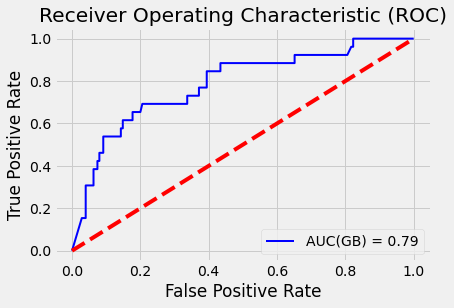

In [12]:

plt.plot(fpr_2, tpr_2, 'b',lw=2, label='AUC(GB) = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Receiver Operating Characteristic (ROC)")
plt.show()


Permutation explainer: 202it [01:36,  1.89it/s]                         


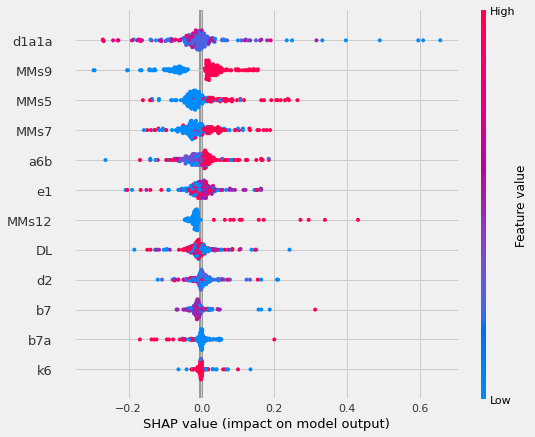

In [13]:
# shap value
explainer = shap.Explainer(model_gb.predict_proba, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values[:, :, 1], X_test, show=False)

plt.show()

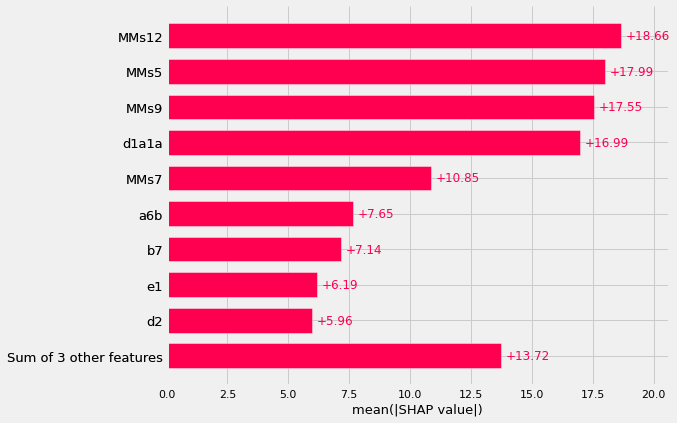

In [14]:
explainer = shap.Explainer(model_gb)
shap_values = explainer(X_train)

shap.plots.bar(shap_values)


Permutation explainer: 1379it [11:07,  2.03it/s]                          


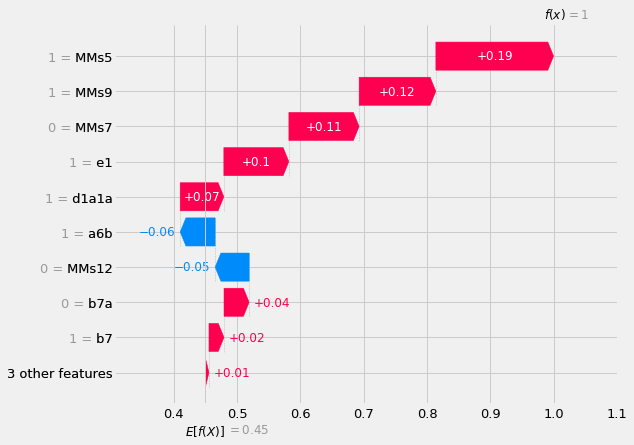

In [15]:

explainer = shap.Explainer(model_gb.predict, X_train)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])



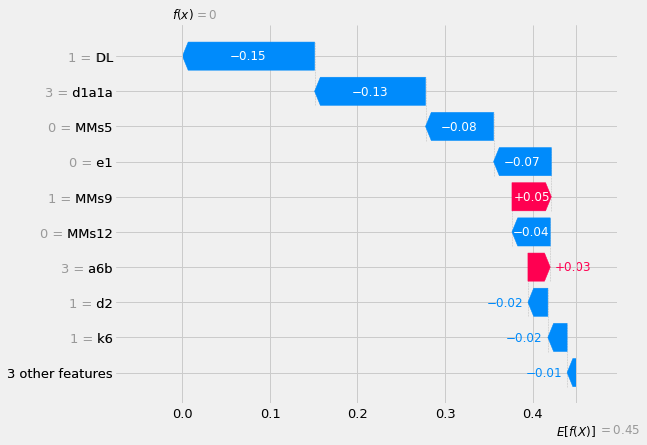

In [16]:

shap.plots.waterfall(shap_values[1])


### Confusion matrix

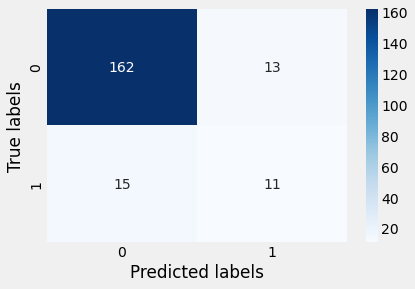

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       175
           1       0.46      0.42      0.44        26

    accuracy                           0.86       201
   macro avg       0.69      0.67      0.68       201
weighted avg       0.86      0.86      0.86       201



In [17]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print(classification_report(y_test, y_pred))

### SHAP decision plot

Explainer expected value: -74.91826264313558


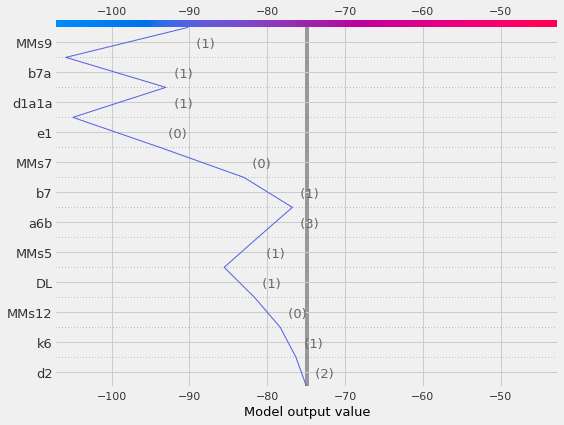

In [18]:
import warnings
explainer = shap.TreeExplainer(model_gb, X_test)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = np.mean(expected_value)
print(f"Explainer expected value: {expected_value}")

select = range(len(X_test))
features = X_test.iloc[select]
features_display = X_test.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[0]
    
    
shap.decision_plot(expected_value, shap_values, features_display)


## II.4- Neural Network

In [19]:
# Define the model as a function for RandomizedSearchCV
def create_model(neurons=35, dropout=0.2, epochs=10, batch_size=5):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up RandomizedSearchCV for hyperparameter tuning

param_dist = {
    'neurons': randint(20, 100),
    'dropout': uniform(0.01, 0.5),
    'epochs': randint(10, 30),
    'batch_size': randint(5, 20),
}

model_nn = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=model_nn,
                                   param_distributions=param_dist, 
                                   cv=cv,
                                   n_jobs=-1,
                                   scoring='accuracy'
                                  )

# Fit the RandomizedSearchCV object to the data
random_search_result = random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search_result.best_params_)

# Evaluate the model using the best hyperparameters
best_model = random_search_result.best_estimator_.model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Calculate performance metrics
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
fpr_3, tpr_3, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_3 = auc(fpr_3, tpr_3)

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


9/9 [==============================] - 0s 697us/step
Best hyperparameters:  {'batch_size': 5, 'dropout': 0.2801069088229139, 'epochs': 21, 'neurons': 64}
Epoch 1/50
44/44 [==============================] - 1s 3ms/step - loss: 0.3657 - accuracy: 0.8353 - val_loss: 0.4267 - val_accuracy: 0.7910
Epoch 2/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3671 - accuracy: 0.8382 - val_loss: 0.4239 - val_accuracy: 0.7861
Epoch 3/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3642 - accuracy: 0.8440 - val_loss: 0.4333 - val_accuracy: 0.7910
Epoch 4/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3668 - accuracy: 0.8505 - val_loss: 0.4368 - val_accuracy: 0.7861
Epoch 5/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3554 - accuracy: 0.8462 - val_loss: 0.4362 - val_accuracy: 0.7861
Epoch 6/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3664 - accuracy: 0.8403 - val_loss: 0.4313 - val_accuracy: 0.7861
Epoch 

44/44 [==============================] - 0s 1ms/step - loss: 0.3425 - accuracy: 0.8454 - val_loss: 0.4406 - val_accuracy: 0.7761
Epoch 41/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3390 - accuracy: 0.8636 - val_loss: 0.4364 - val_accuracy: 0.7711
Epoch 42/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3366 - accuracy: 0.8549 - val_loss: 0.4362 - val_accuracy: 0.7711
Epoch 43/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3438 - accuracy: 0.8534 - val_loss: 0.4329 - val_accuracy: 0.7711
Epoch 44/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3297 - accuracy: 0.8628 - val_loss: 0.4488 - val_accuracy: 0.7711
Epoch 45/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3257 - accuracy: 0.8585 - val_loss: 0.4354 - val_accuracy: 0.7811
Epoch 46/50
44/44 [==============================] - 0s 1ms/step - loss: 0.3329 - accuracy: 0.8607 - val_loss: 0.4206 - val_accuracy: 0.7910
Epoch 47/50
44/44 [======

In [20]:
### Roc curve

Accuracy: 0.7860696517412935
Precision: 0.6170940170940171
Recall: 0.6806593406593406
F1 score: 0.6322284158120931
AUC: 0.8117582417582417


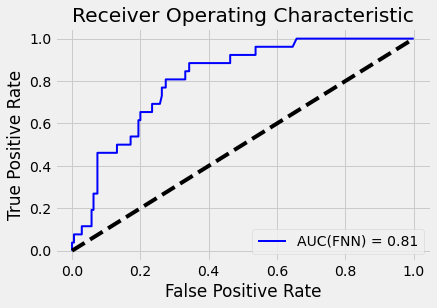

In [21]:
# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)
print("AUC:", roc_auc_3)

# Plot ROC curve
plt.plot(fpr_3, tpr_3, 'b',lw=2, label='AUC(FNN) = %0.2f' % roc_auc_3)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Feature analysis with shap

37/37 [==============================] - 0s 429us/step


29/29 [==============================] - 0s 457us/step


Permutation explainer:   4%|▍         | 8/201 [00:00<?, ?it/s]

30/30 [==============================] - 0s 478us/step


Permutation explainer:   5%|▍         | 10/201 [00:12<02:04,  1.54it/s]

32/32 [==============================] - 0s 521us/step


Permutation explainer:   5%|▌         | 11/201 [00:13<02:56,  1.08it/s]

31/31 [==============================] - 0s 467us/step


Permutation explainer:   6%|▌         | 12/201 [00:15<03:25,  1.09s/it]

30/30 [==============================] - 0s 455us/step


Permutation explainer:   6%|▋         | 13/201 [00:16<03:39,  1.17s/it]

33/33 [==============================] - 0s 468us/step


Permutation explainer:   7%|▋         | 14/201 [00:17<03:51,  1.24s/it]

31/31 [==============================] - 0s 518us/step


Permutation explainer:   7%|▋         | 15/201 [00:19<03:58,  1.28s/it]

29/29 [==============================] - 0s 483us/step


Permutation explainer:   8%|▊         | 16/201 [00:20<03:59,  1.29s/it]

29/29 [==============================] - 0s 492us/step


Permutation explainer:   8%|▊         | 17/201 [00:21<04:01,  1.31s/it]

28/28 [==============================] - 0s 510us/step


Permutation explainer:   9%|▉         | 18/201 [00:23<04:01,  1.32s/it]

28/28 [==============================] - 0s 495us/step


Permutation explainer:   9%|▉         | 19/201 [00:24<03:59,  1.32s/it]

30/30 [==============================] - 0s 471us/step


Permutation explainer:  10%|▉         | 20/201 [00:25<03:59,  1.32s/it]

31/31 [==============================] - 0s 464us/step


Permutation explainer:  10%|█         | 21/201 [00:27<04:03,  1.35s/it]

27/27 [==============================] - 0s 495us/step


Permutation explainer:  11%|█         | 22/201 [00:28<03:58,  1.33s/it]

27/27 [==============================] - 0s 481us/step


Permutation explainer:  11%|█▏        | 23/201 [00:29<03:56,  1.33s/it]

31/31 [==============================] - 0s 495us/step


Permutation explainer:  12%|█▏        | 24/201 [00:31<03:54,  1.33s/it]

30/30 [==============================] - 0s 485us/step


Permutation explainer:  12%|█▏        | 25/201 [00:32<03:55,  1.34s/it]

33/33 [==============================] - 0s 465us/step


Permutation explainer:  13%|█▎        | 26/201 [00:33<03:56,  1.35s/it]

31/31 [==============================] - 0s 467us/step


Permutation explainer:  13%|█▎        | 27/201 [00:35<03:57,  1.36s/it]

30/30 [==============================] - 0s 486us/step


Permutation explainer:  14%|█▍        | 28/201 [00:36<04:08,  1.43s/it]

30/30 [==============================] - 0s 495us/step


Permutation explainer:  14%|█▍        | 29/201 [00:38<04:06,  1.43s/it]

28/28 [==============================] - 0s 544us/step


Permutation explainer:  15%|█▍        | 30/201 [00:39<04:00,  1.41s/it]

28/28 [==============================] - 0s 561us/step


Permutation explainer:  15%|█▌        | 31/201 [00:40<03:55,  1.38s/it]

34/34 [==============================] - 0s 497us/step


Permutation explainer:  16%|█▌        | 32/201 [00:42<03:59,  1.41s/it]

28/28 [==============================] - 0s 470us/step


Permutation explainer:  16%|█▋        | 33/201 [00:43<03:53,  1.39s/it]

32/32 [==============================] - 0s 542us/step


Permutation explainer:  17%|█▋        | 34/201 [00:45<03:49,  1.38s/it]

35/35 [==============================] - 0s 458us/step


Permutation explainer:  17%|█▋        | 35/201 [00:46<03:50,  1.39s/it]

32/32 [==============================] - 0s 498us/step


Permutation explainer:  18%|█▊        | 36/201 [00:47<03:43,  1.36s/it]

29/29 [==============================] - 0s 473us/step


Permutation explainer:  18%|█▊        | 37/201 [00:49<03:37,  1.32s/it]

30/30 [==============================] - 0s 462us/step


Permutation explainer:  19%|█▉        | 38/201 [00:50<03:35,  1.32s/it]

27/27 [==============================] - 0s 501us/step


Permutation explainer:  19%|█▉        | 39/201 [00:51<03:27,  1.28s/it]

33/33 [==============================] - 0s 454us/step


Permutation explainer:  20%|█▉        | 40/201 [00:52<03:30,  1.31s/it]

30/30 [==============================] - 0s 458us/step


Permutation explainer:  20%|██        | 41/201 [00:54<03:30,  1.32s/it]

32/32 [==============================] - 0s 500us/step


Permutation explainer:  21%|██        | 42/201 [00:55<03:33,  1.34s/it]

31/31 [==============================] - 0s 477us/step


Permutation explainer:  21%|██▏       | 43/201 [00:57<03:34,  1.36s/it]

30/30 [==============================] - 0s 476us/step


Permutation explainer:  22%|██▏       | 44/201 [00:58<03:30,  1.34s/it]

31/31 [==============================] - 0s 476us/step


Permutation explainer:  22%|██▏       | 45/201 [00:59<03:30,  1.35s/it]

27/27 [==============================] - 0s 484us/step


Permutation explainer:  23%|██▎       | 46/201 [01:00<03:25,  1.32s/it]

29/29 [==============================] - 0s 428us/step


Permutation explainer:  23%|██▎       | 47/201 [01:02<03:25,  1.33s/it]

30/30 [==============================] - 0s 463us/step


Permutation explainer:  24%|██▍       | 48/201 [01:03<03:24,  1.34s/it]

29/29 [==============================] - 0s 462us/step


Permutation explainer:  24%|██▍       | 49/201 [01:04<03:19,  1.31s/it]

28/28 [==============================] - 0s 437us/step


Permutation explainer:  25%|██▍       | 50/201 [01:06<03:15,  1.30s/it]

28/28 [==============================] - 0s 519us/step


Permutation explainer:  25%|██▌       | 51/201 [01:07<03:14,  1.29s/it]

27/27 [==============================] - 0s 470us/step


Permutation explainer:  26%|██▌       | 52/201 [01:08<03:10,  1.28s/it]

29/29 [==============================] - 0s 479us/step


Permutation explainer:  26%|██▋       | 53/201 [01:10<03:10,  1.29s/it]

31/31 [==============================] - 0s 485us/step


Permutation explainer:  27%|██▋       | 54/201 [01:11<03:09,  1.29s/it]

29/29 [==============================] - 0s 462us/step


Permutation explainer:  27%|██▋       | 55/201 [01:12<03:06,  1.28s/it]

28/28 [==============================] - 0s 442us/step


Permutation explainer:  28%|██▊       | 56/201 [01:13<03:04,  1.27s/it]

28/28 [==============================] - 0s 514us/step


Permutation explainer:  28%|██▊       | 57/201 [01:15<03:02,  1.26s/it]

33/33 [==============================] - 0s 455us/step


Permutation explainer:  29%|██▉       | 58/201 [01:16<03:06,  1.30s/it]

32/32 [==============================] - 0s 472us/step


Permutation explainer:  29%|██▉       | 59/201 [01:17<03:10,  1.34s/it]

30/30 [==============================] - 0s 478us/step


Permutation explainer:  30%|██▉       | 60/201 [01:19<03:09,  1.35s/it]

29/29 [==============================] - 0s 500us/step


Permutation explainer:  30%|███       | 61/201 [01:20<03:05,  1.32s/it]

29/29 [==============================] - 0s 489us/step


Permutation explainer:  31%|███       | 62/201 [01:21<03:01,  1.31s/it]

26/26 [==============================] - 0s 453us/step


Permutation explainer:  31%|███▏      | 63/201 [01:22<02:55,  1.27s/it]

31/31 [==============================] - 0s 446us/step


Permutation explainer:  32%|███▏      | 64/201 [01:24<03:01,  1.32s/it]

27/27 [==============================] - 0s 525us/step


Permutation explainer:  32%|███▏      | 65/201 [01:25<03:00,  1.33s/it]

31/31 [==============================] - 0s 502us/step


Permutation explainer:  33%|███▎      | 66/201 [01:27<03:01,  1.34s/it]

33/33 [==============================] - 0s 485us/step


Permutation explainer:  33%|███▎      | 67/201 [01:28<03:03,  1.37s/it]

29/29 [==============================] - 0s 454us/step


Permutation explainer:  34%|███▍      | 68/201 [01:29<03:03,  1.38s/it]

29/29 [==============================] - 0s 488us/step


Permutation explainer:  34%|███▍      | 69/201 [01:31<03:00,  1.37s/it]

32/32 [==============================] - 0s 468us/step


Permutation explainer:  35%|███▍      | 70/201 [01:32<02:56,  1.35s/it]

32/32 [==============================] - 0s 454us/step


Permutation explainer:  35%|███▌      | 71/201 [01:33<02:55,  1.35s/it]

34/34 [==============================] - 0s 458us/step


Permutation explainer:  36%|███▌      | 72/201 [01:35<02:52,  1.34s/it]

28/28 [==============================] - 0s 497us/step


Permutation explainer:  36%|███▋      | 73/201 [01:36<02:49,  1.32s/it]

28/28 [==============================] - 0s 557us/step


Permutation explainer:  37%|███▋      | 74/201 [01:37<02:45,  1.30s/it]

33/33 [==============================] - 0s 614us/step


Permutation explainer:  37%|███▋      | 75/201 [01:39<02:44,  1.31s/it]

30/30 [==============================] - 0s 477us/step


Permutation explainer:  38%|███▊      | 76/201 [01:40<02:42,  1.30s/it]

30/30 [==============================] - 0s 488us/step


Permutation explainer:  38%|███▊      | 77/201 [01:41<02:42,  1.31s/it]

32/32 [==============================] - 0s 467us/step


Permutation explainer:  39%|███▉      | 78/201 [01:43<02:46,  1.35s/it]

33/33 [==============================] - 0s 437us/step


Permutation explainer:  39%|███▉      | 79/201 [01:44<02:50,  1.40s/it]

30/30 [==============================] - 0s 446us/step


Permutation explainer:  40%|███▉      | 80/201 [01:46<02:47,  1.38s/it]

29/29 [==============================] - 0s 454us/step


Permutation explainer:  40%|████      | 81/201 [01:47<02:42,  1.36s/it]

27/27 [==============================] - 0s 460us/step


Permutation explainer:  41%|████      | 82/201 [01:48<02:38,  1.33s/it]

28/28 [==============================] - 0s 496us/step


Permutation explainer:  41%|████▏     | 83/201 [01:50<02:40,  1.36s/it]

27/27 [==============================] - 0s 456us/step


Permutation explainer:  42%|████▏     | 84/201 [01:51<02:37,  1.35s/it]

29/29 [==============================] - 0s 486us/step


Permutation explainer:  42%|████▏     | 85/201 [01:52<02:36,  1.35s/it]

31/31 [==============================] - 0s 460us/step


Permutation explainer:  43%|████▎     | 86/201 [01:54<02:37,  1.37s/it]

29/29 [==============================] - 0s 485us/step


Permutation explainer:  43%|████▎     | 87/201 [01:55<02:36,  1.37s/it]

32/32 [==============================] - 0s 436us/step


Permutation explainer:  44%|████▍     | 88/201 [01:56<02:35,  1.37s/it]

29/29 [==============================] - 0s 494us/step


Permutation explainer:  44%|████▍     | 89/201 [01:58<02:30,  1.34s/it]

29/29 [==============================] - 0s 515us/step


Permutation explainer:  45%|████▍     | 90/201 [01:59<02:26,  1.32s/it]

29/29 [==============================] - 0s 483us/step


Permutation explainer:  45%|████▌     | 91/201 [02:00<02:23,  1.30s/it]

35/35 [==============================] - 0s 531us/step


Permutation explainer:  46%|████▌     | 92/201 [02:02<02:24,  1.33s/it]

30/30 [==============================] - 0s 497us/step


Permutation explainer:  46%|████▋     | 93/201 [02:03<02:23,  1.33s/it]

33/33 [==============================] - 0s 458us/step


Permutation explainer:  47%|████▋     | 94/201 [02:04<02:24,  1.35s/it]

30/30 [==============================] - 0s 452us/step


Permutation explainer:  47%|████▋     | 95/201 [02:06<02:24,  1.36s/it]

29/29 [==============================] - 0s 507us/step


Permutation explainer:  48%|████▊     | 96/201 [02:07<02:21,  1.34s/it]

29/29 [==============================] - 0s 453us/step


Permutation explainer:  48%|████▊     | 97/201 [02:08<02:18,  1.33s/it]

34/34 [==============================] - 0s 446us/step


Permutation explainer:  49%|████▉     | 98/201 [02:10<02:17,  1.33s/it]

30/30 [==============================] - 0s 537us/step


Permutation explainer:  49%|████▉     | 99/201 [02:11<02:17,  1.35s/it]

30/30 [==============================] - 0s 473us/step


Permutation explainer:  50%|████▉     | 100/201 [02:12<02:16,  1.35s/it]

31/31 [==============================] - 0s 472us/step


Permutation explainer:  50%|█████     | 101/201 [02:14<02:15,  1.35s/it]

28/28 [==============================] - 0s 467us/step


Permutation explainer:  51%|█████     | 102/201 [02:15<02:12,  1.34s/it]

34/34 [==============================] - 0s 496us/step


Permutation explainer:  51%|█████     | 103/201 [02:17<02:15,  1.38s/it]

28/28 [==============================] - 0s 486us/step


Permutation explainer:  52%|█████▏    | 104/201 [02:18<02:11,  1.36s/it]

31/31 [==============================] - 0s 476us/step


Permutation explainer:  52%|█████▏    | 105/201 [02:19<02:10,  1.36s/it]

29/29 [==============================] - 0s 485us/step


Permutation explainer:  53%|█████▎    | 106/201 [02:21<02:08,  1.35s/it]

30/30 [==============================] - 0s 433us/step


Permutation explainer:  53%|█████▎    | 107/201 [02:22<02:08,  1.36s/it]

32/32 [==============================] - 0s 519us/step


Permutation explainer:  54%|█████▎    | 108/201 [02:23<02:07,  1.38s/it]

30/30 [==============================] - 0s 454us/step


Permutation explainer:  54%|█████▍    | 109/201 [02:25<02:03,  1.34s/it]

29/29 [==============================] - 0s 460us/step


Permutation explainer:  55%|█████▍    | 110/201 [02:26<02:00,  1.33s/it]

31/31 [==============================] - 0s 507us/step


Permutation explainer:  55%|█████▌    | 111/201 [02:27<01:59,  1.33s/it]

29/29 [==============================] - 0s 457us/step


Permutation explainer:  56%|█████▌    | 112/201 [02:29<01:56,  1.31s/it]

29/29 [==============================] - 0s 474us/step


Permutation explainer:  56%|█████▌    | 113/201 [02:30<01:54,  1.30s/it]

29/29 [==============================] - 0s 553us/step


Permutation explainer:  57%|█████▋    | 114/201 [02:31<01:53,  1.30s/it]

35/35 [==============================] - 0s 486us/step


Permutation explainer:  57%|█████▋    | 115/201 [02:33<01:55,  1.34s/it]

32/32 [==============================] - 0s 491us/step


Permutation explainer:  58%|█████▊    | 116/201 [02:34<01:54,  1.35s/it]

28/28 [==============================] - 0s 521us/step


Permutation explainer:  58%|█████▊    | 117/201 [02:35<01:53,  1.35s/it]

31/31 [==============================] - 0s 444us/step


Permutation explainer:  59%|█████▊    | 118/201 [02:37<01:51,  1.35s/it]

27/27 [==============================] - 0s 445us/step


Permutation explainer:  59%|█████▉    | 119/201 [02:38<01:48,  1.32s/it]

29/29 [==============================] - 0s 444us/step


Permutation explainer:  60%|█████▉    | 120/201 [02:39<01:46,  1.31s/it]

32/32 [==============================] - 0s 464us/step


Permutation explainer:  60%|██████    | 121/201 [02:40<01:45,  1.32s/it]

29/29 [==============================] - 0s 498us/step


Permutation explainer:  61%|██████    | 122/201 [02:42<01:43,  1.31s/it]

29/29 [==============================] - 0s 519us/step


Permutation explainer:  61%|██████    | 123/201 [02:43<01:41,  1.30s/it]

30/30 [==============================] - 0s 457us/step


Permutation explainer:  62%|██████▏   | 124/201 [02:44<01:39,  1.30s/it]

30/30 [==============================] - 0s 436us/step


Permutation explainer:  62%|██████▏   | 125/201 [02:46<01:38,  1.30s/it]

28/28 [==============================] - 0s 480us/step


Permutation explainer:  63%|██████▎   | 126/201 [02:47<01:36,  1.29s/it]

29/29 [==============================] - 0s 470us/step


Permutation explainer:  63%|██████▎   | 127/201 [02:48<01:34,  1.27s/it]

29/29 [==============================] - 0s 446us/step


Permutation explainer:  64%|██████▎   | 128/201 [02:49<01:33,  1.28s/it]

28/28 [==============================] - 0s 465us/step


Permutation explainer:  64%|██████▍   | 129/201 [02:51<01:32,  1.29s/it]

30/30 [==============================] - 0s 431us/step


Permutation explainer:  65%|██████▍   | 130/201 [02:52<01:31,  1.28s/it]

29/29 [==============================] - 0s 452us/step


Permutation explainer:  65%|██████▌   | 131/201 [02:53<01:30,  1.29s/it]

31/31 [==============================] - 0s 451us/step


Permutation explainer:  66%|██████▌   | 132/201 [02:55<01:29,  1.30s/it]

34/34 [==============================] - 0s 431us/step


Permutation explainer:  66%|██████▌   | 133/201 [02:56<01:30,  1.33s/it]

29/29 [==============================] - 0s 451us/step


Permutation explainer:  67%|██████▋   | 134/201 [02:57<01:27,  1.31s/it]

28/28 [==============================] - 0s 464us/step


Permutation explainer:  67%|██████▋   | 135/201 [02:59<01:25,  1.29s/it]

28/28 [==============================] - 0s 460us/step


Permutation explainer:  68%|██████▊   | 136/201 [03:00<01:22,  1.27s/it]

26/26 [==============================] - 0s 451us/step


Permutation explainer:  68%|██████▊   | 137/201 [03:01<01:24,  1.32s/it]

32/32 [==============================] - 0s 530us/step


Permutation explainer:  69%|██████▊   | 138/201 [03:03<01:24,  1.34s/it]

32/32 [==============================] - 0s 442us/step


Permutation explainer:  69%|██████▉   | 139/201 [03:04<01:24,  1.36s/it]

28/28 [==============================] - 0s 450us/step


Permutation explainer:  70%|██████▉   | 140/201 [03:05<01:22,  1.35s/it]

30/30 [==============================] - 0s 438us/step


Permutation explainer:  70%|███████   | 141/201 [03:07<01:20,  1.34s/it]

31/31 [==============================] - 0s 507us/step


Permutation explainer:  71%|███████   | 142/201 [03:08<01:19,  1.35s/it]

30/30 [==============================] - 0s 492us/step


Permutation explainer:  71%|███████   | 143/201 [03:09<01:16,  1.33s/it]

30/30 [==============================] - 0s 452us/step


Permutation explainer:  72%|███████▏  | 144/201 [03:11<01:14,  1.31s/it]

30/30 [==============================] - 0s 463us/step


Permutation explainer:  72%|███████▏  | 145/201 [03:12<01:12,  1.30s/it]

32/32 [==============================] - 0s 476us/step


Permutation explainer:  73%|███████▎  | 146/201 [03:13<01:11,  1.30s/it]

32/32 [==============================] - 0s 465us/step


Permutation explainer:  73%|███████▎  | 147/201 [03:14<01:11,  1.32s/it]

28/28 [==============================] - 0s 484us/step


Permutation explainer:  74%|███████▎  | 148/201 [03:16<01:08,  1.30s/it]

29/29 [==============================] - 0s 454us/step


Permutation explainer:  74%|███████▍  | 149/201 [03:17<01:07,  1.29s/it]

28/28 [==============================] - 0s 479us/step


Permutation explainer:  75%|███████▍  | 150/201 [03:18<01:05,  1.28s/it]

29/29 [==============================] - 0s 481us/step


Permutation explainer:  75%|███████▌  | 151/201 [03:20<01:03,  1.28s/it]

32/32 [==============================] - 0s 483us/step


Permutation explainer:  76%|███████▌  | 152/201 [03:21<01:02,  1.28s/it]

33/33 [==============================] - 0s 473us/step


Permutation explainer:  76%|███████▌  | 153/201 [03:22<01:03,  1.31s/it]

29/29 [==============================] - 0s 551us/step


Permutation explainer:  77%|███████▋  | 154/201 [03:23<01:01,  1.31s/it]

31/31 [==============================] - 0s 448us/step


Permutation explainer:  77%|███████▋  | 155/201 [03:25<01:00,  1.31s/it]

27/27 [==============================] - 0s 492us/step


Permutation explainer:  78%|███████▊  | 156/201 [03:26<00:58,  1.29s/it]

25/25 [==============================] - 0s 460us/step


Permutation explainer:  78%|███████▊  | 157/201 [03:27<00:56,  1.27s/it]

30/30 [==============================] - 0s 460us/step


Permutation explainer:  79%|███████▊  | 158/201 [03:29<00:56,  1.31s/it]

34/34 [==============================] - 0s 476us/step


Permutation explainer:  79%|███████▉  | 159/201 [03:30<00:55,  1.31s/it]

32/32 [==============================] - 0s 454us/step


Permutation explainer:  80%|███████▉  | 160/201 [03:31<00:54,  1.32s/it]

33/33 [==============================] - 0s 477us/step


Permutation explainer:  80%|████████  | 161/201 [03:33<00:53,  1.34s/it]

28/28 [==============================] - 0s 542us/step


Permutation explainer:  81%|████████  | 162/201 [03:34<00:52,  1.33s/it]

27/27 [==============================] - 0s 444us/step


Permutation explainer:  81%|████████  | 163/201 [03:35<00:49,  1.31s/it]

31/31 [==============================] - 0s 507us/step


Permutation explainer:  82%|████████▏ | 164/201 [03:37<00:48,  1.31s/it]

29/29 [==============================] - 0s 443us/step


Permutation explainer:  82%|████████▏ | 165/201 [03:38<00:46,  1.30s/it]

30/30 [==============================] - 0s 438us/step


Permutation explainer:  83%|████████▎ | 166/201 [03:39<00:45,  1.29s/it]

31/31 [==============================] - 0s 493us/step


Permutation explainer:  83%|████████▎ | 167/201 [03:41<00:44,  1.31s/it]

27/27 [==============================] - 0s 481us/step


Permutation explainer:  84%|████████▎ | 168/201 [03:42<00:43,  1.31s/it]

29/29 [==============================] - 0s 467us/step


Permutation explainer:  84%|████████▍ | 169/201 [03:43<00:41,  1.29s/it]

27/27 [==============================] - 0s 491us/step


Permutation explainer:  85%|████████▍ | 170/201 [03:44<00:39,  1.27s/it]

31/31 [==============================] - 0s 498us/step


Permutation explainer:  85%|████████▌ | 171/201 [03:46<00:38,  1.28s/it]

31/31 [==============================] - 0s 571us/step


Permutation explainer:  86%|████████▌ | 172/201 [03:47<00:37,  1.28s/it]

31/31 [==============================] - 0s 475us/step


Permutation explainer:  86%|████████▌ | 173/201 [03:48<00:36,  1.31s/it]

30/30 [==============================] - 0s 449us/step


Permutation explainer:  87%|████████▋ | 174/201 [03:50<00:35,  1.31s/it]

27/27 [==============================] - 0s 470us/step


Permutation explainer:  87%|████████▋ | 175/201 [03:51<00:33,  1.28s/it]

29/29 [==============================] - 0s 459us/step


Permutation explainer:  88%|████████▊ | 176/201 [03:52<00:32,  1.29s/it]

29/29 [==============================] - 0s 544us/step


Permutation explainer:  88%|████████▊ | 177/201 [03:53<00:30,  1.28s/it]

29/29 [==============================] - 0s 451us/step


Permutation explainer:  89%|████████▊ | 178/201 [03:55<00:29,  1.28s/it]

29/29 [==============================] - 0s 517us/step


Permutation explainer:  89%|████████▉ | 179/201 [03:56<00:28,  1.27s/it]

32/32 [==============================] - 0s 472us/step


Permutation explainer:  90%|████████▉ | 180/201 [03:57<00:27,  1.29s/it]

29/29 [==============================] - 0s 506us/step


Permutation explainer:  90%|█████████ | 181/201 [03:59<00:25,  1.29s/it]

34/34 [==============================] - 0s 439us/step


Permutation explainer:  91%|█████████ | 182/201 [04:00<00:25,  1.32s/it]

31/31 [==============================] - 0s 467us/step


Permutation explainer:  91%|█████████ | 183/201 [04:01<00:23,  1.32s/it]

31/31 [==============================] - 0s 464us/step


Permutation explainer:  92%|█████████▏| 184/201 [04:03<00:22,  1.31s/it]

30/30 [==============================] - 0s 463us/step


Permutation explainer:  92%|█████████▏| 185/201 [04:04<00:20,  1.31s/it]

29/29 [==============================] - 0s 531us/step


Permutation explainer:  93%|█████████▎| 186/201 [04:05<00:19,  1.31s/it]

29/29 [==============================] - 0s 455us/step


Permutation explainer:  93%|█████████▎| 187/201 [04:06<00:18,  1.29s/it]

34/34 [==============================] - 0s 429us/step


Permutation explainer:  94%|█████████▎| 188/201 [04:08<00:17,  1.33s/it]

28/28 [==============================] - 0s 487us/step


Permutation explainer:  94%|█████████▍| 189/201 [04:09<00:15,  1.32s/it]

29/29 [==============================] - 0s 493us/step


Permutation explainer:  95%|█████████▍| 190/201 [04:10<00:14,  1.31s/it]

28/28 [==============================] - 0s 562us/step


Permutation explainer:  95%|█████████▌| 191/201 [04:12<00:13,  1.37s/it]

30/30 [==============================] - 0s 494us/step


Permutation explainer:  96%|█████████▌| 192/201 [04:13<00:12,  1.41s/it]

36/36 [==============================] - 0s 453us/step


Permutation explainer:  96%|█████████▌| 193/201 [04:15<00:12,  1.50s/it]

29/29 [==============================] - 0s 469us/step


Permutation explainer:  97%|█████████▋| 194/201 [04:17<00:10,  1.50s/it]

30/30 [==============================] - 0s 459us/step


Permutation explainer:  97%|█████████▋| 195/201 [04:18<00:08,  1.47s/it]

29/29 [==============================] - 0s 478us/step


Permutation explainer:  98%|█████████▊| 196/201 [04:19<00:07,  1.43s/it]

35/35 [==============================] - 0s 503us/step


Permutation explainer:  98%|█████████▊| 197/201 [04:21<00:05,  1.46s/it]

29/29 [==============================] - 0s 480us/step


Permutation explainer:  99%|█████████▊| 198/201 [04:22<00:04,  1.41s/it]

30/30 [==============================] - 0s 462us/step


Permutation explainer:  99%|█████████▉| 199/201 [04:23<00:02,  1.37s/it]

31/31 [==============================] - 0s 467us/step


Permutation explainer: 100%|█████████▉| 200/201 [04:25<00:01,  1.35s/it]

29/29 [==============================] - 0s 496us/step


Permutation explainer: 100%|██████████| 201/201 [04:26<00:00,  1.31s/it]

30/30 [==============================] - 0s 449us/step


Permutation explainer: 202it [04:27,  1.38s/it]                         


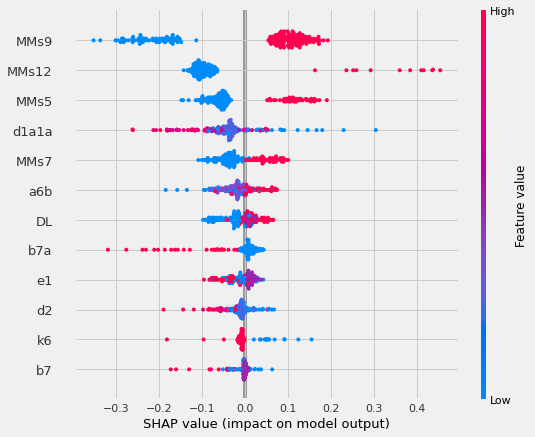

In [22]:
#Compute SHAP values
explainer = shap.Explainer(best_model.predict, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

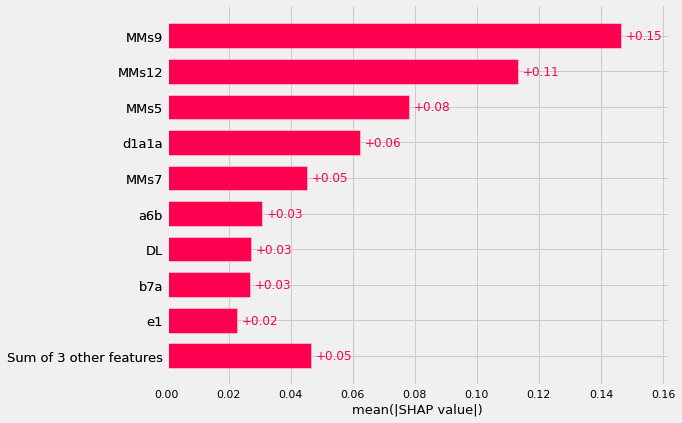

In [23]:

shap.plots.bar(shap_values)

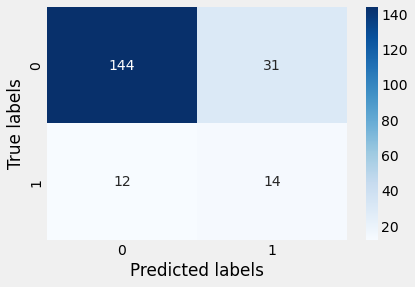

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       175
           1       0.31      0.54      0.39        26

    accuracy                           0.79       201
   macro avg       0.62      0.68      0.63       201
weighted avg       0.84      0.79      0.81       201



In [24]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print(classification_report(y_test, y_pred))

## II.5 - Logistic Regression

In [25]:

model_lr = LogisticRegression()

# Define the hyperparameters to tune
param_dist = {
    'penalty': ['l2'], 
    'C': uniform(0.01, 0.5),
    'solver': ['newton-cg', 'liblinear', 'sag']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation and hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model_lr, 
                                   param_distributions=param_dist, 
                                   cv=cv,
                                   scoring='accuracy',
                                   verbose=0, 
                                   n_jobs=-1, 
                                   n_iter=20, 
                                   random_state=42)

random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", random_search.best_params_)

# Train the model using the best hyperparameters
model_lr = random_search.best_estimator_
model_lr.fit(X_train, y_train)

# Make predictions using the best model
y_pred = model_lr.predict(X_test)

# Print accuracy score and classification report
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nes

Best hyperparameters:  {'C': 0.19727005942368125, 'penalty': 'l2', 'solver': 'newton-cg'}


### Roc curve

Accuracy: 0.7064676616915423
Precision: 0.5863122171945702
Recall: 0.6676923076923077
F1-score: 0.5809688703579379
AUC: 0.7699999999999999


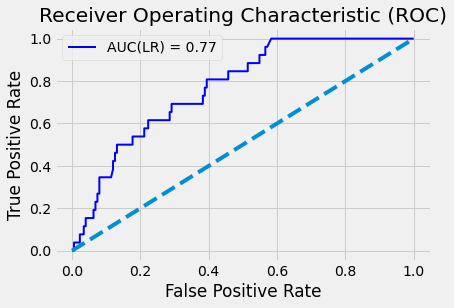

In [26]:
print("Accuracy:", accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
# Compute ROC curve and AUC
fpr_4, tpr_4, thresholds = roc_curve(y_test, model_lr.predict_proba(X_test)[:, 1])
roc_auc_4 = auc(fpr_4, tpr_4)
print("AUC:", roc_auc_4)

plt.plot(fpr_4, tpr_4, 'b',lw=2, label='AUC(LR) = %0.2f' % roc_auc_4)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

### Confusion matrix

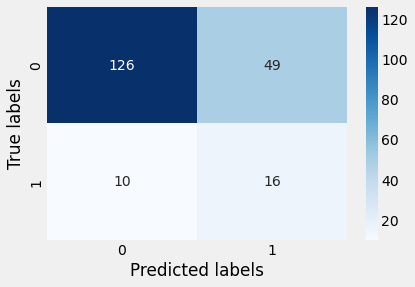

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       175
           1       0.25      0.62      0.35        26

    accuracy                           0.71       201
   macro avg       0.59      0.67      0.58       201
weighted avg       0.84      0.71      0.75       201



In [27]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print(classification_report(y_test, y_pred))

### Feature Analyis with shap value

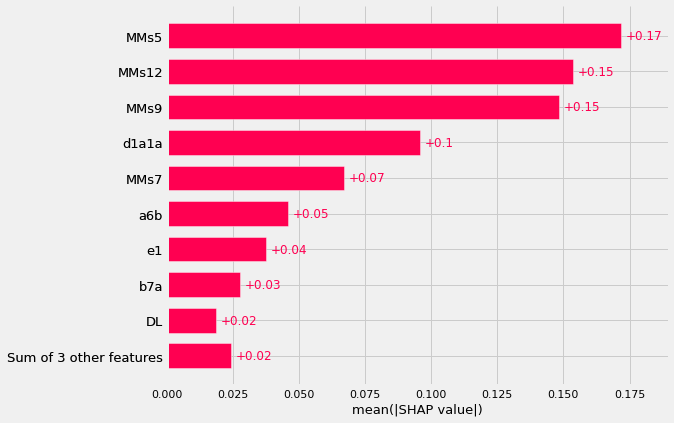

In [28]:
#Compute SHAP values
explainer = shap.Explainer(model_lr.predict, X_train)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

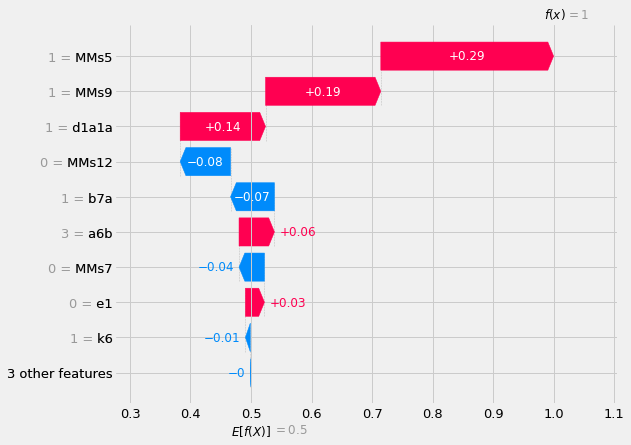

In [29]:

shap.plots.waterfall(shap_values[0])

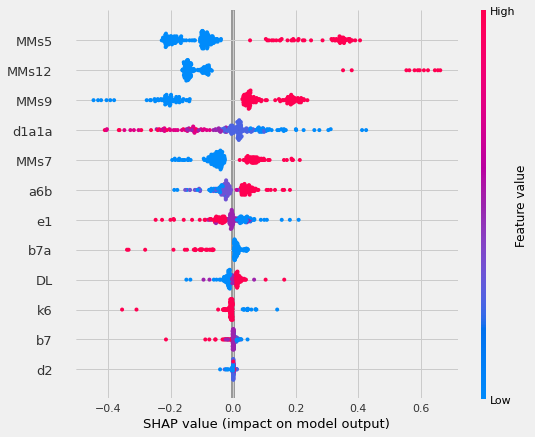

In [30]:

shap.summary_plot(shap_values,X_test)

# Comparative ROC Curve

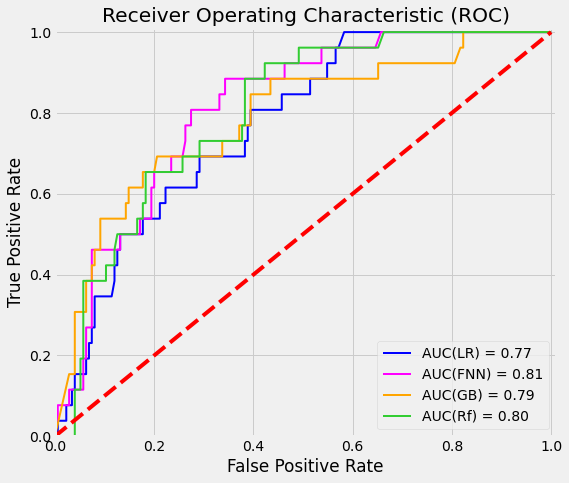

In [31]:

plt.figure(figsize=(8,7))
plt.plot(fpr_4, tpr_4,"blue", lw=2, label='AUC(LR) = %0.2f' % roc_auc_4)
plt.plot(fpr_3, tpr_3, "magenta",lw=2, label='AUC(FNN) = %0.2f' % roc_auc_3)
plt.plot(fpr_2, tpr_2,"orange",lw=2, label='AUC(GB) = %0.2f' % roc_auc_2)
plt.plot(fpr_1, tpr_1,"limegreen", lw=2, label='AUC(Rf) = %0.2f' % roc_auc_1)
plt.plot([0, 1], [0, 1],"r", linestyle="--")
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim([0, 1.01])
plt.xlim([0,1.01])
plt.legend(loc="lower right")
plt.show()

# Partial dependence

To investigate the individual impact of each feature, we employed the Shap dependence plot, which enables us to observe variations in the Shap value across different categories of each feature. Figure below presents the dependence plot for the feature that we have identified as the most significant for the prediction using GB algorithm. This analytical approach employed in the study facilitates a comprehensive understanding of the specific influence exerted by each feature on the outcome under investigation.

In [32]:
df1=data.copy()

X1 = df1.drop("MMs3", axis=1)
y1 = df1["MMs3"]

X_train_v, X_test_v, y_train, y_test = train_test_split(X1, y1, test_size=0.15, random_state=42)

X_train_v=X_train_v.dropna()
X_train_ = X_train_v.apply(le.fit_transform)

explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_train_)


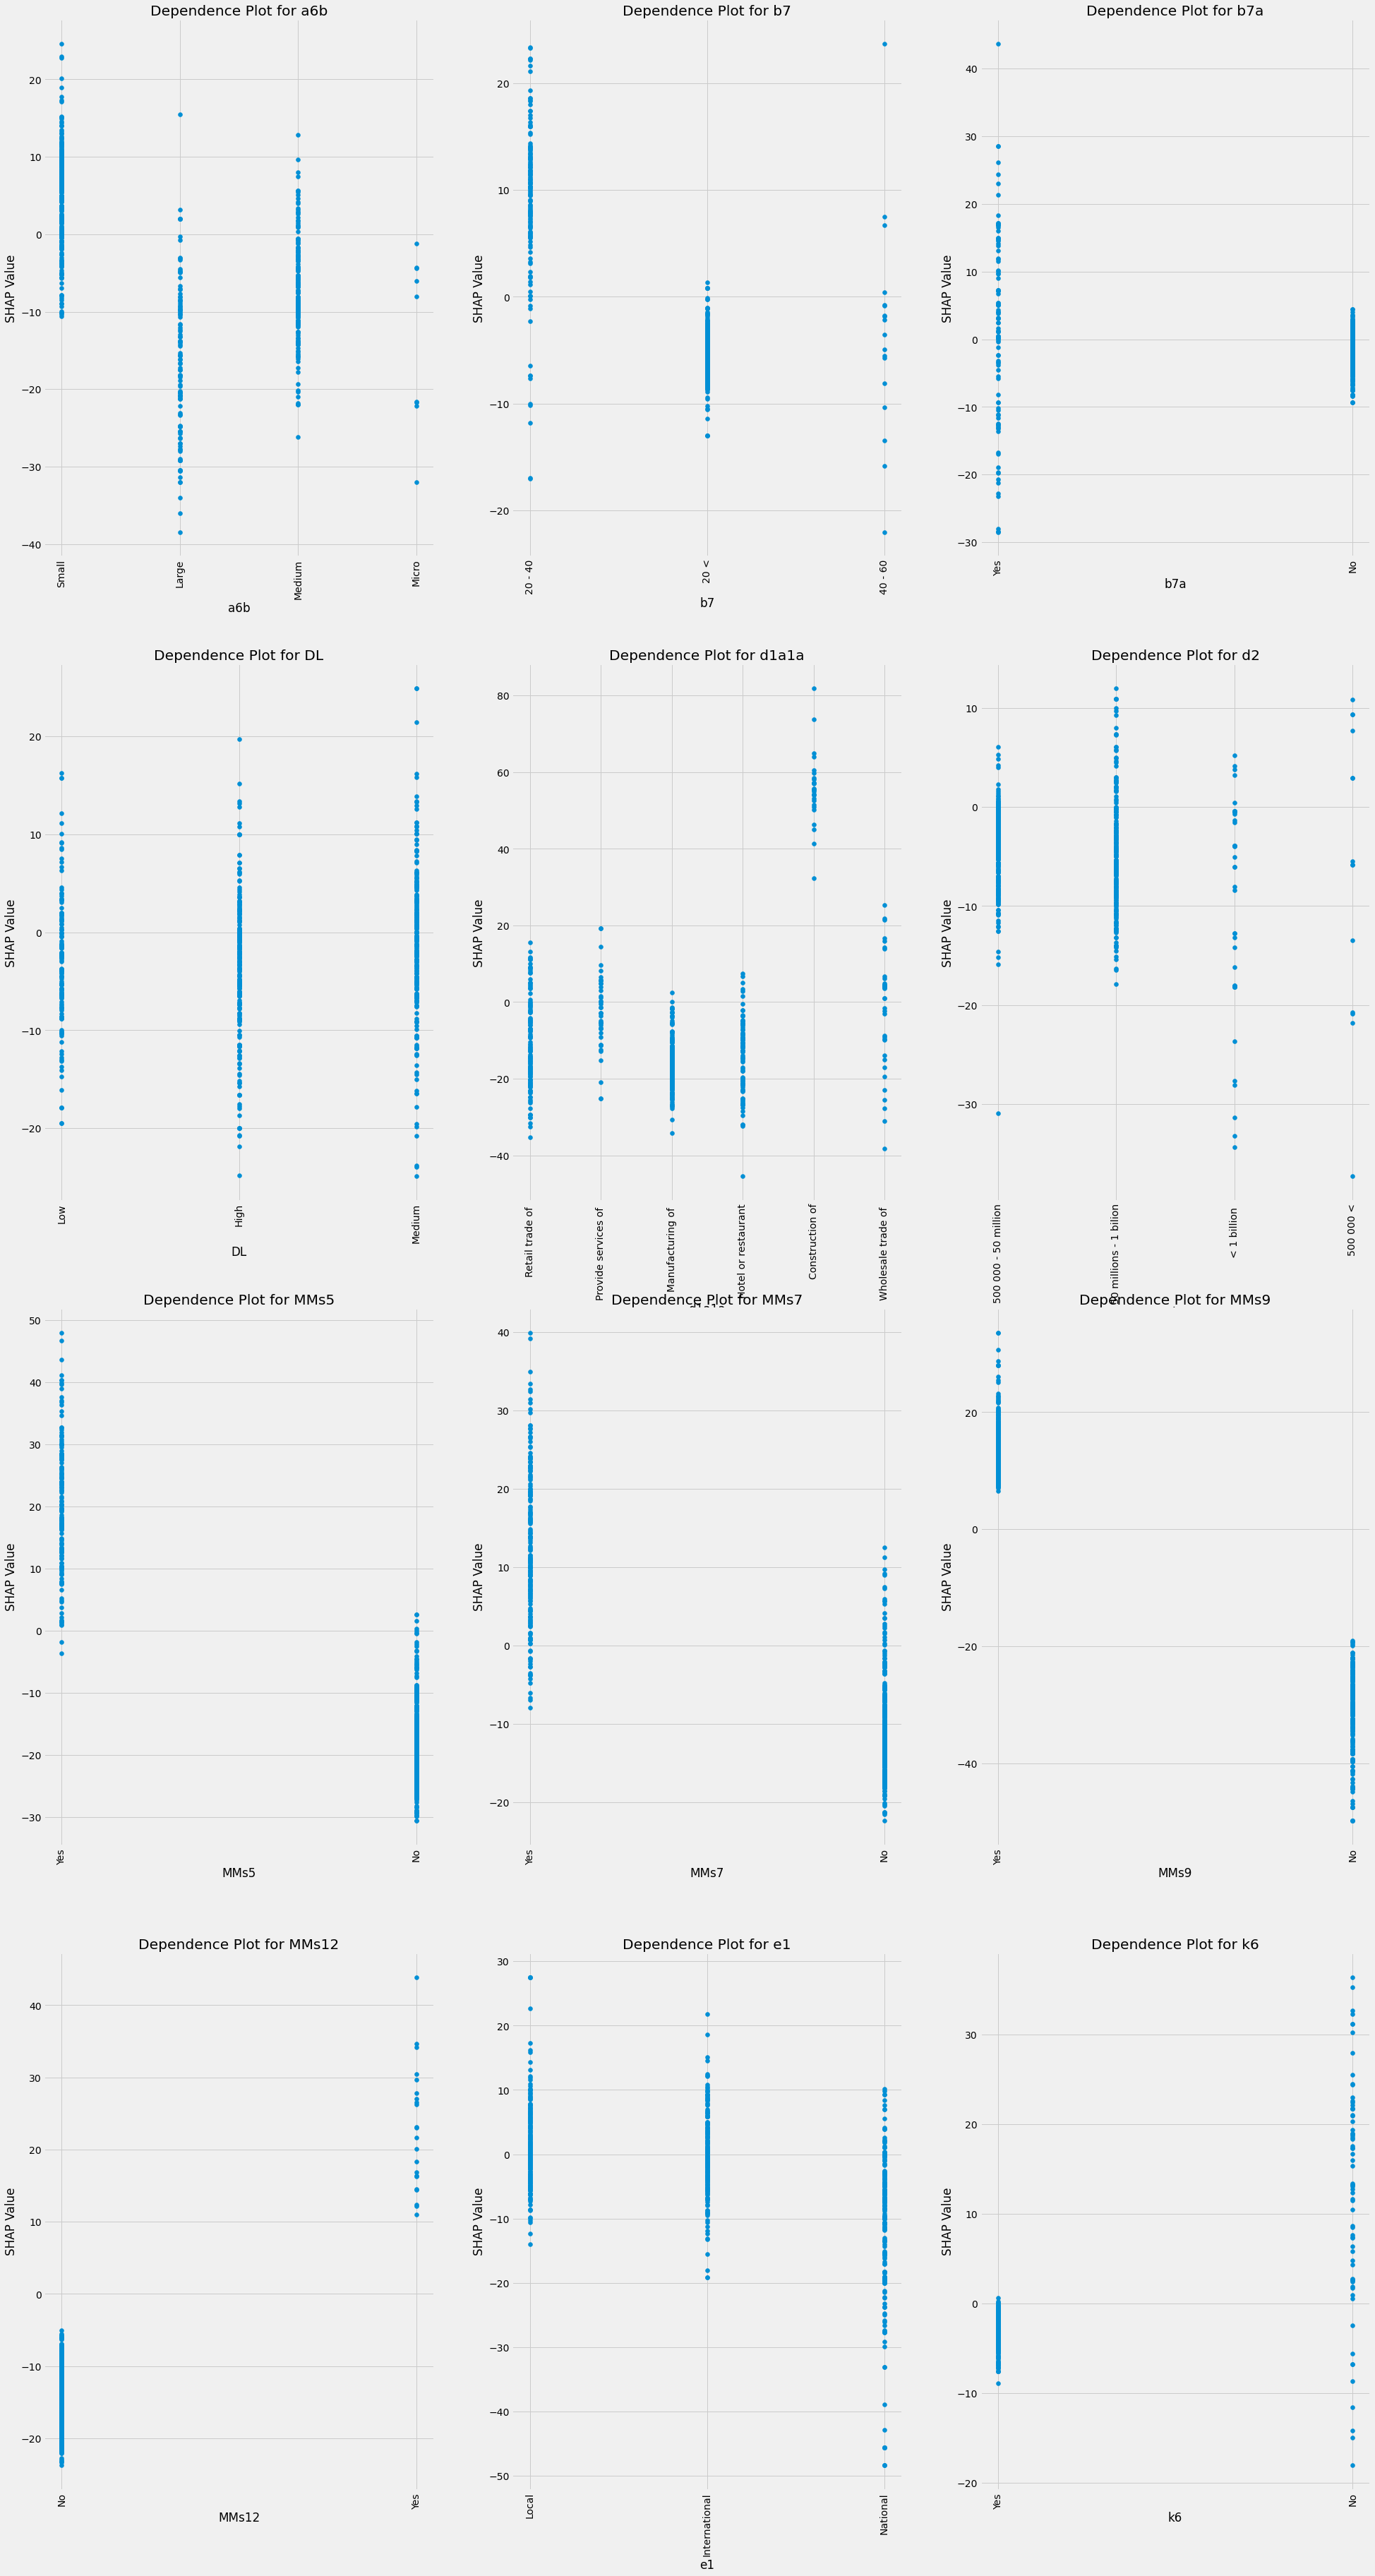

In [33]:
import matplotlib.pyplot as plt

feature_names = X_train_v.columns  # Assuming X_test is a pandas DataFrame with named columns
plt.figure(figsize=(30,60))
for i in range(12):

    x_values = X_train_v[feature_names[i]].astype(str)  # Convert values to strings
    plt.subplot(4,3,i+1)
    plt.xticks(range(len(x_values.unique())), x_values.unique(), rotation='vertical')
    plt.xlabel(feature_names[i])
    plt.ylabel("SHAP Value")
    plt.title(f"Dependence Plot for {feature_names[i]}")
    plt.scatter(x_values, shap_values[:, i])
